# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [1]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
FEATURE_COLS = ['OT']
EPOCHS = 40 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K_hat = 12                  # number of VMD modes (tuneable)
alpha_hat = 1705             # VMD alpha (tuneable)
tau_hat = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda, Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import random
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate


In [3]:
save_dir = os.path.expanduser("~/Project/Nested_Attention_BiLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


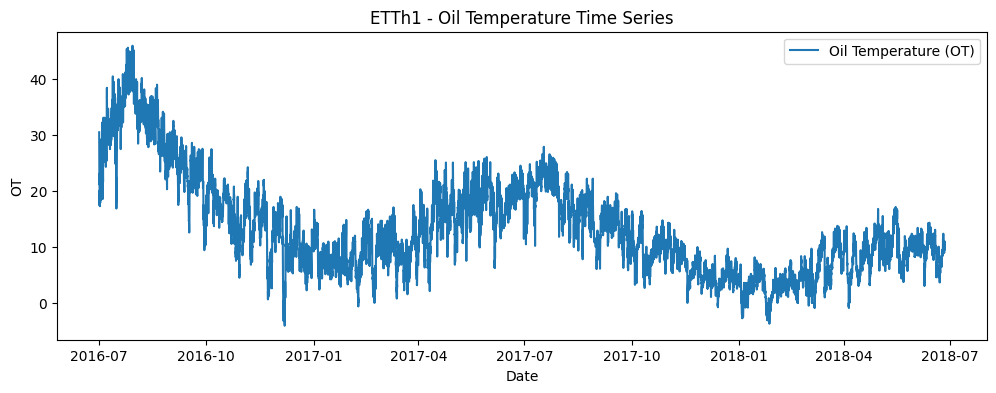

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [5]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
X_train, X_test = df[FEATURE_COLS].values[:split_idx], df[FEATURE_COLS].values[split_idx:]
y_train, y_test = df[TARGET_COL].values[:split_idx].reshape(-1,1), df[TARGET_COL].values[split_idx:].reshape(-1,1)

# =====================================================
# Helper: Create sequences
# =====================================================
def create_sequences_vmd(X, y, seq_len, alpha, tau, K):
    """
    Create sequences of length seq_len and apply VMD on each sequence (X only)
    If alpha=0, tau=0, K=1: no VMD applied (simple sequence)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        seq_x = X[i:i+seq_len]          # shape: (seq_len, num_features)
        seq_y = y[i+seq_len]            # target aligned after the sequence

        if alpha > 0 and K > 1:
            # Apply VMD on each feature independently
            seq_x_vmd_list = []
            for f in range(seq_x.shape[1]):
                u, _, _ = VMD(seq_x[:, f], alpha, tau, K, DC=0, init=1, tol=1e-7)
                seq_x_vmd_list.append(np.stack(u, axis=1))  # (seq_len, K)
            # Concatenate VMD modes of all features: (seq_len, K*num_features)
            seq_x = np.concatenate(seq_x_vmd_list, axis=1)

        Xs.append(seq_x)
        ys.append(seq_y)

    return np.array(Xs), np.array(ys)

# =====================================================
# Train/Test Sequences
# =====================================================
# VMD sequences
X_train_vmd_seq, y_train_vmd_seq = create_sequences_vmd(X_train, y_train, SEQ_LEN, alpha_hat, tau_hat, K_hat)
X_test_vmd_seq,  y_test_vmd_seq  = create_sequences_vmd(X_test,  y_test,  SEQ_LEN, alpha_hat, tau_hat, K_hat)

# Simple sequences (no VMD)
X_train_simple_seq, y_train_simple_seq = create_sequences_vmd(X_train, y_train, SEQ_LEN, alpha=0, tau=0, K=1)
X_test_simple_seq, y_test_simple_seq   = create_sequences_vmd(X_test, y_test, SEQ_LEN, alpha=0, tau=0, K=1)

# =====================================================
# Scale X sequences
# =====================================================
scaler_x = MinMaxScaler()

# VMD sequences
num_train_seq, seq_len, feat_dim_vmd = X_train_vmd_seq.shape
X_train_vmd_scaled = scaler_x.fit_transform(X_train_vmd_seq.reshape(-1, feat_dim_vmd)).reshape(num_train_seq, seq_len, feat_dim_vmd)
num_test_seq = X_test_vmd_seq.shape[0]
X_test_vmd_scaled = scaler_x.transform(X_test_vmd_seq.reshape(-1, feat_dim_vmd)).reshape(num_test_seq, seq_len, feat_dim_vmd)

# Simple sequences
num_train_seq_s, seq_len_s, feat_dim_s = X_train_simple_seq.shape
X_train_simple_scaled = scaler_x.fit_transform(X_train_simple_seq.reshape(-1, feat_dim_s)).reshape(num_train_seq_s, seq_len_s, feat_dim_s)
num_test_seq_s = X_test_simple_seq.shape[0]
X_test_simple_scaled = scaler_x.transform(X_test_simple_seq.reshape(-1, feat_dim_s)).reshape(num_test_seq_s, seq_len_s, feat_dim_s)

# =====================================================
# Scale y (target) sequences
# =====================================================
scaler_y = MinMaxScaler()
y_train_vmd_scaled = scaler_y.fit_transform(y_train_vmd_seq.reshape(-1,1))
y_test_vmd_scaled  = scaler_y.transform(y_test_vmd_seq.reshape(-1,1))

y_train_simple_scaled = scaler_y.fit_transform(y_train_simple_seq.reshape(-1,1))
y_test_simple_scaled  = scaler_y.transform(y_test_simple_seq.reshape(-1,1))

# =====================================================
# Inverse-transform true y for plotting
# =====================================================
y_test_vmd_true    = scaler_y.inverse_transform(y_test_vmd_scaled)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple_scaled)


/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:114: RuntimeWarning: invalid value encountered in scalar divide
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:112: RuntimeWarning: invalid value encountered in divide
  u_hat_plus[n+1,:,k] = (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1+Alpha[k]*(freqs - omega_plus[n,k])**2)


In [8]:
X_train_vmd_seq.shape

(13912, 24, 12)

## CUSTOM LAYERS

In [78]:
# ===================================================
# PERFORMER ATTENTION
# ===================================================
class PerformerAttention(Layer):
    def __init__(self, num_heads, model_dim, kernel_eps=1e-6, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.kernel_eps = kernel_eps
        self.dropout = Dropout(dropout)
        self.head_dim = model_dim // num_heads
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

    def build(self, input_shape):
        # Linear projections
        self.Wq = Dense(self.model_dim)
        self.Wk = Dense(self.model_dim)
        self.Wv = Dense(self.model_dim)
        self.Wo = Dense(self.model_dim)
        
        # Random Gaussian projection for FAVOR+
        self.proj = self.add_weight(
            shape=(self.head_dim, self.head_dim),
            initializer="random_normal",
            trainable=False,
            name="proj_matrix"
        )

    def kernel(self, x):
        # FAVOR+ kernel Φ(x)
        x_proj = tf.einsum("...nd,df->...nf", x, self.proj)
        return tf.nn.relu(x_proj) + self.kernel_eps

    def split_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = tf.reshape(x, (B, T, self.num_heads, self.head_dim))
        return tf.transpose(x, [0, 2, 1, 3])  # (B, H, T, Dh)

    def merge_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[2]
        x = tf.transpose(x, [0, 2, 1, 3])
        return tf.reshape(x, (B, T, self.model_dim))

    def call(self, x, training=False):
        Q, K, V = x  # all shape (B, T, model_dim)
        
        # Linear projections + split heads
        Q = self.split_heads(self.Wq(Q))
        K = self.split_heads(self.Wk(K))
        V = self.split_heads(self.Wv(V))
        
        # FAVOR+ kernel
        Q_phi = self.kernel(Q)  # (B, H, T, Dh)
        K_phi = self.kernel(K)
        
        # Compute KV and normalization
        KV = tf.einsum("bhnd,bhne->bhde", K_phi, V)  # (B,H,Dh,Dh)
        Z = 1.0 / (tf.einsum("bhnd,bhd->bhn", Q_phi, tf.reduce_sum(K_phi, axis=2)) + 1e-6)
        out = tf.einsum("bhnd,bhde,bhn->bhne", Q_phi, KV, Z)
        
        # Merge heads
        out = self.merge_heads(out)
        return self.Wo(out)

# ===================================================
# VAE SAMPLING LAYER
# ===================================================
class KLDivergenceLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        kl = -0.5 * tf.reduce_mean(
            1 + log_var - tf.square(mu) - tf.exp(log_var)
        )
        self.add_loss(kl)
        return inputs
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
    
# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation='tanh')
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context
        
def build_Tattlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model
# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]



# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# ========================================================= 
class TFTTemporalAttention(Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1,
                 use_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate
        self.use_mask = use_mask
        
        assert model_dim % num_heads == 0
        self.head_dim = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.Wo = Dense(model_dim)

        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def build(self, input_shape):
        self.Wq.build(input_shape[0])
        self.Wk.build(input_shape[0])
        self.Wv.build(input_shape[0])
        self.Wo.build((None, None, self.model_dim))
        self.layernorm.build((None, None, self.model_dim))
        self.built = True

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1,
                           self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        encoder_out, decoder_state = inputs

        batch_size = tf.shape(encoder_out)[0]

        dec_expanded = tf.repeat(
            tf.expand_dims(decoder_state, axis=1),
            repeats=tf.shape(encoder_out)[1],
            axis=1
        )

        Q = self.Wq(dec_expanded)
        K = self.Wk(encoder_out)
        V = self.Wv(encoder_out)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.cast(tf.sqrt(float(self.head_dim)), tf.float32)
        score = score / scale

        if self.use_mask:
            T = tf.shape(encoder_out)[1]
            mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
            mask = 1e-9 * (1 - mask)
            score += mask

        alpha = tf.nn.softmax(score, axis=-1)
        att_out = tf.matmul(alpha, V)

        att_out = tf.transpose(att_out, perm=[0, 2, 1, 3])
        att_out = tf.reshape(att_out,
                             (batch_size, -1, self.model_dim))

        out = self.Wo(att_out)

        # residual: input must have same dim
        out = self.layernorm(out)

        return out


def build_TFTattlstm_model(input_shape, lstm1_units=100, lstm2_units=100,
                            dense_units=32, num_heads=8, model_dim=64, dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    enc_out = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    enc_out = Dropout(dropout)(enc_out)
    enc_out = LayerNormalization()(enc_out)
    enc_out = Dense(model_dim)(enc_out)  # project to model_dim
    enc_out = LayerNormalization()(enc_out)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_1 = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_enc = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_1)

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    dec_out = LSTM(lstm2_units, return_sequences=True)(bahdanau_att_enc)
    dec_out = Dropout(dropout)(dec_out)
    dec_out = Dense(model_dim)(dec_out)  # ensure same feature dimension
    dec_out = LayerNormalization()(dec_out)

    # Bahdanau attention over decoder
    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)  # shape: (batch, model_dim)

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_enc, bahdanau_att_dec])

    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(encoder_inputs, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

def build_TFTattlstm_model2(input_shape, lstm1_units=100, lstm2_units=100,
                            dense_units=32, num_heads=8, model_dim=64, dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    # Bahdanau attention over decoder
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])

    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(input_group, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model


def build_TFTattlstm_model3(input_shape=(24,8), 
                            lstm1_units=100,
                            dense_units=32, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)   # (24, 8)

    # -------------------------
    # **Split input: group1 = first 4 features, group2 = next 4**
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)   # (24, 4)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)   # (24, 4)
    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)
    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)
    # -------------------------
    # 3. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])
    # -------------------------
    # 4. Dense Output
    # -------------------------
    output = Dense(1)(x)
    # -------------------------
    # 5. Compile Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model



# ============================
# BUILD Performer attlstm MODEL WITH cross attention
# ============================

def build_TFTattlstm_model4(
        input_shape=(24,8), 
        lstm1_units=100,
        dense_units=32, 
        num_heads=8, 
        model_dim=64,
        dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)   # (24, 8)

    # -------------------------
    # Split input
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)   
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)   

    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)

    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)

    # -------------------------
    # 3. Cross Attention
    # -------------------------
    cross = CrossAttention(num_heads=num_heads, key_dim=model_dim)

    g1_to_g2 = cross(query=bahdanau_att_group1, context=bahdanau_att_group2)
    g2_to_g1 = cross(query=bahdanau_att_group2, context=bahdanau_att_group1)
    cross_out = Concatenate(axis=1)([g1_to_g2, g2_to_g1])  # shape: (batch, 2, model_dim)

    # -------------------------
    # 4. Multi-Head Attention (replaces Performer)
    # -------------------------
    mha = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)
    att_out = mha(query=cross_out, value=cross_out, key=cross_out)
    att_out = Dropout(dropout)(att_out)
    att_out = LayerNormalization(epsilon=1e-6)(att_out)

    # -------------------------
    # 5. LSTM + Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 6. Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model
# ============================
# BUILD TFTattlstm MODEL WITH VAE
# ============================
def build_TFTattlstm_model5(
        input_shape=(24, 8),
        lstm1_units=100,
        dense_units=32,
        latent_dim=16,
        num_heads=8,
        model_dim=64,
        dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Split Inputs
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # -------------------------
    # 2. LSTM + Bahdanau Group1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau1 = AttentionLayer_Bahdanau()(group1)
    bahdanau1 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau1)

    # -------------------------
    # 3. LSTM + Bahdanau Group2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau2 = AttentionLayer_Bahdanau()(group2)
    bahdanau2 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau2)

    # -------------------------
    # 4. CONCAT Bahdanau outputs
    # -------------------------
    combined = Concatenate(axis=1)([bahdanau1, bahdanau2])   # (batch, 2, features)

    # -------------------------
    # 5. Flatten for VAE Encoder
    # -------------------------
    flat = Flatten()(combined)
    flat_dim = flat.shape[-1]     # static

    # -------------------------
    # 6. VAE Encoder
    # -------------------------
    mu = Dense(latent_dim)(flat)
    log_var = Dense(latent_dim)(flat)

    # Apply KL divergence correctly
    mu, log_var = KLDivergenceLayer()([mu, log_var])

    # Sampling
    z = Sampling()([mu, log_var])

    # -------------------------
    # 7. VAE Decoder
    # -------------------------
    decoder_hidden = Dense(64, activation="relu")(z)
    decoder_out = Dense(flat_dim, activation="linear")(decoder_hidden)

    decoder_out_reshaped = Reshape((2, flat_dim // 2))(decoder_out)

    # -------------------------
    # 8. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([decoder_out_reshaped, decoder_out_reshaped])

    # -------------------------
    # 9. LSTM + Dense Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 10. Final Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER
# ============================
def build_TFTattlstm_model6(input_shape=(24,8), 
                            lstm1_units=64,
                            dense_units=8, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # 0. Input
    input_group = Input(shape=input_shape)   # (seq_len, features)

    # 1. Split input
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # 2. LSTM for group1
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    # 3. LSTM for group2
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    # 4. Performer Attention on each group
    performer_att_group1 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group1, group1, group1]
    )
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )

    # Take last time step for each group
    performer_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(performer_att_group1)
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(performer_att_group2)

    # 5. Concatenate
    cross_out = Concatenate()([performer_att_group1, performer_att_group2])

    # 6. Dense + Output
    x = Dense(dense_units, activation='relu')(cross_out)
    output = Dense(1)(x)

    # 7. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER and BAHDANAU
# ============================
def build_TFTattlstm_model7(input_shape=(24,8), 
                            lstm1_units=64,
                            dense_units=8, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # 0. Input
    input_group = Input(shape=input_shape)   # (seq_len, features)


    # 2. LSTM for group1
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    # 3. LSTM for group2
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    # 4. Bahdanau Attention for group1
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    # Expand dims to match Performer output shape
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1), name="group1_bahdanau_expand")(bahdanau_att_group1)
    # Take last step
    bahdanau_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(bahdanau_att_group1)

    # 5. Performer Attention for group2
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(performer_att_group2)

    # 6. Concatenate
    cross_out = Concatenate()([bahdanau_att_group1, performer_att_group2])

    # 7. Dense + Output
    x = Dense(dense_units, activation='relu')(cross_out)
    output = Dense(1)(x)

    # 8. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

    return model


# AttLSTM+VMD

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 24, 132)        │        74,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_8     │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,633 (939.97 KB)

 Trainable params: 240,633 (939.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0060 - mae: 0.0486 - val_loss: 6.7520e-04 - val_mae: 0.0189
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0016 - mae: 0.0301 - val_loss: 7.3313e-04 - val_mae: 0.0214
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 4.8640e-04 - val_mae: 0.0159
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 4.3119e-04 - val_mae: 0.0150
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 4.4982e-04 - val_mae: 0.0158
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9.8033e-04 - mae: 0.0232 - val_loss: 3.9975e-04 - val_mae: 0.0148
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.9327e-04 - mae: 0.0234 - val_loss: 4.9856e-04 - val_mae: 0.0167
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 9.0588e-04 - mae: 0.0222 - val_loss: 4.6072e-04 - val_mae: 0.0162
Epoc

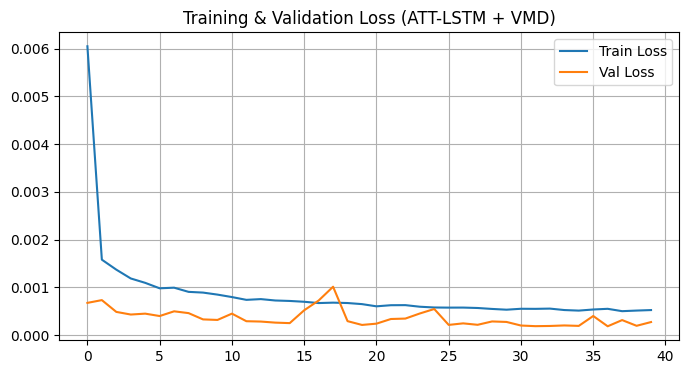

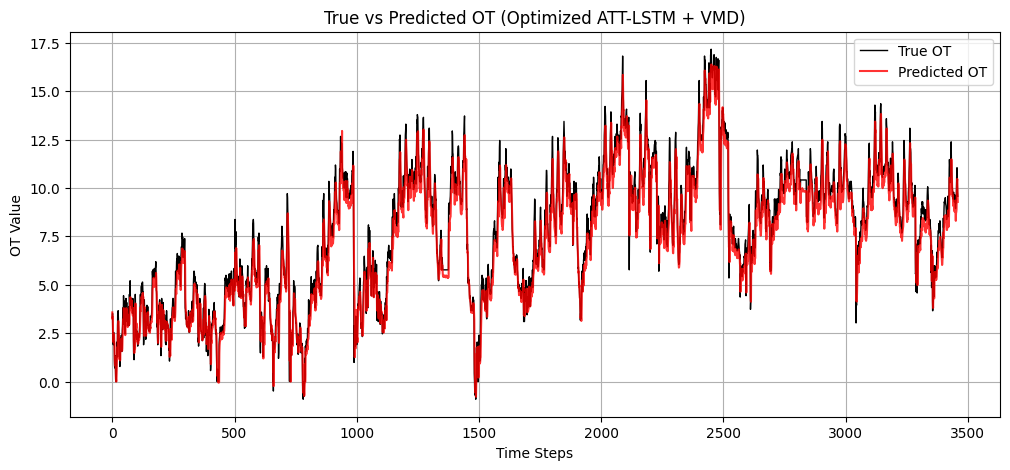

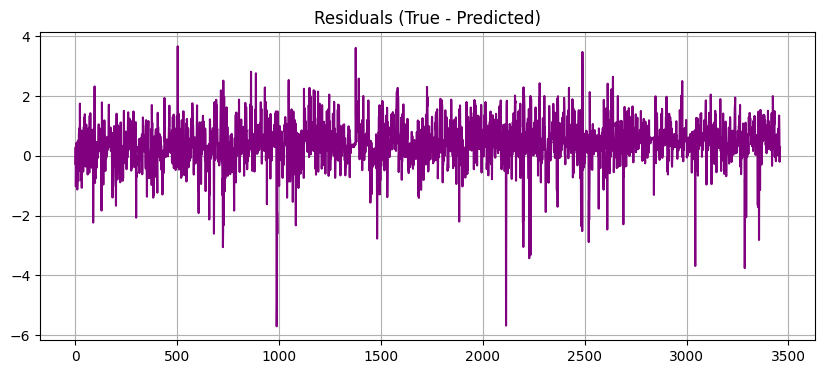

Total Area = 2225.9057650244804
Area + = 1865.3059388375855
Area - = -360.59982618689526


In [19]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_attlstm_model.summary()

history_attlstm_vmd = model_build_attlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_scaled = model_build_attlstm_model.predict(X_test_vmd_scaled)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
area_total_attlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_vmd)
area_positive_attlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_vmd)
print("Area - =", area_negative_attlstm_vmd)

# TAttLSTM+VMD
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 24, 132)        │        74,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention              │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,634 (939.98 KB)

 Trainable params: 240,634 (939.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0053 - mae: 0.0451 - val_loss: 8.4386e-04 - val_mae: 0.0225
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0017 - mae: 0.0313 - val_loss: 6.2645e-04 - val_mae: 0.0192
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 5.1102e-04 - val_mae: 0.0167
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 7.7367e-04 - val_mae: 0.0219
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0013 - val_mae: 0.0310
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.7152e-04 - mae: 0.0231 - val_loss: 3.9767e-04 - val_mae: 0.0145
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9.2317e-04 - mae: 0.0226 - val_loss: 3.7364e-04 - val_mae: 0.0145
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 8.9203e-04 - mae: 0.0222 - val_loss: 5.4771e-04 - val_mae: 0.0190
Epoch 9/

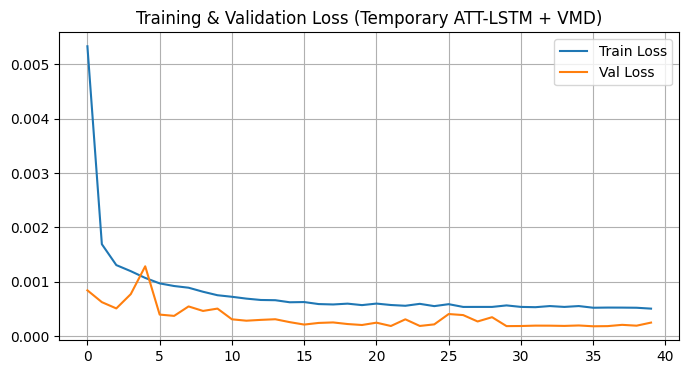

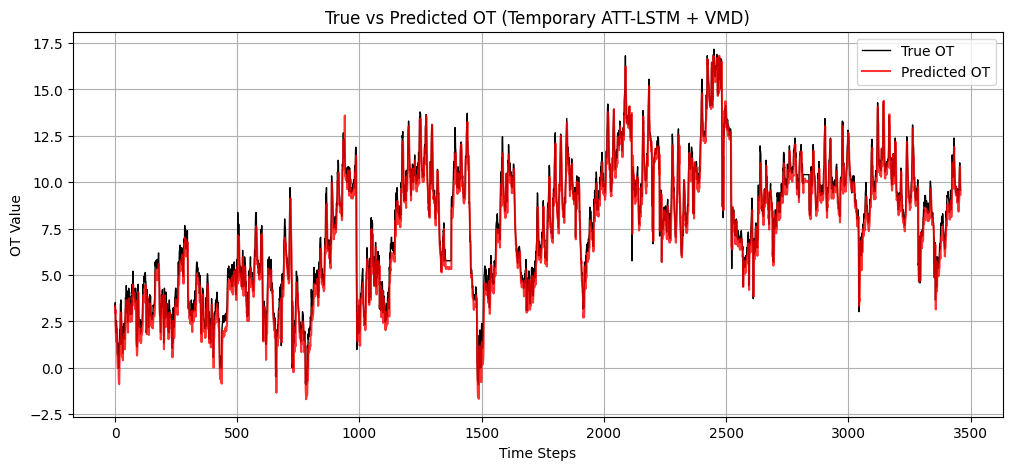

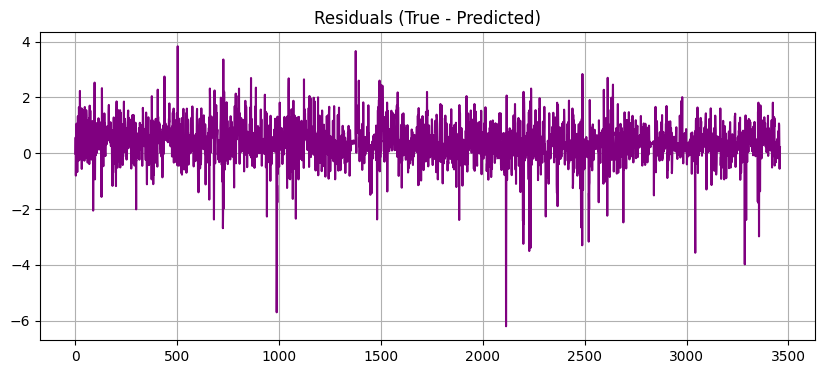

Total Area = 2072.45744301146
Area + = 1716.1073876074527
Area - = -356.3500554040072


In [20]:
model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_Tattlstm_model.summary()

history_Tattlstm_vmd = model_build_Tattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_Tattlstm_vmd_scaled = model_build_Tattlstm_model.predict(X_test_vmd_scaled)
y_pred_Tattlstm_vmd_true = scaler_y.inverse_transform(y_pred_Tattlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_Tattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_Tattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (Temporary ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_Tattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Temporary ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_Tattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
area_total_Tattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Tattlstm_vmd)
area_positive_Tattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_Tattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Tattlstm_vmd)
print("Area - =", area_negative_Tattlstm_vmd)

# TFT Multi-Head Temporal self-Attention lstm

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_107 (LSTM)     │ (None, 24, 128)   │     72,192 │ input_layer_40[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_125         │ (None, 24, 128)   │          0 │ lstm_107[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ dropout_125[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_217 (Dense)   │ (None, 24, 64)    │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_217[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_134 (Lambda) │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_108 (LSTM)     │ (None, 1, 128)    │     98,816 │ lambda_134[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_126         │ (None, 1, 128)    │          0 │ lstm_108[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_218 (Dense)   │ (None, 1, 64)     │      8,256 │ dropout_126[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ dense_218[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ lambda_134[0][0], │
│ (TFTTemporalAttent… │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_30    │ (None, 32)        │     10,368 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_223 (Dense)   │ (None, 1)         │         33 │ bidirectional_30… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 223,649 (873.63 KB)

 Trainable params: 223,649 (873.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0054 - mae: 0.0460 - val_loss: 6.5481e-04 - val_mae: 0.0188
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0014 - mae: 0.0290 - val_loss: 8.5882e-04 - val_mae: 0.0233
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 4.8888e-04 - val_mae: 0.0163
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0011 - mae: 0.0255 - val_loss: 3.9354e-04 - val_mae: 0.0145
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 0.0012 - val_mae: 0.0316
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 9.6128e-04 - mae: 0.0235 - val_loss: 3.8112e-04 - val_mae: 0.0154
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 8.2131e-04 - mae: 0.0215 - val_loss: 2.9561e-04 - val_mae: 0.0126
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 7.5394e-04 - mae: 0.0207 - val_loss: 2.6113e-04 - val_mae: 0.0116
Epoch 9

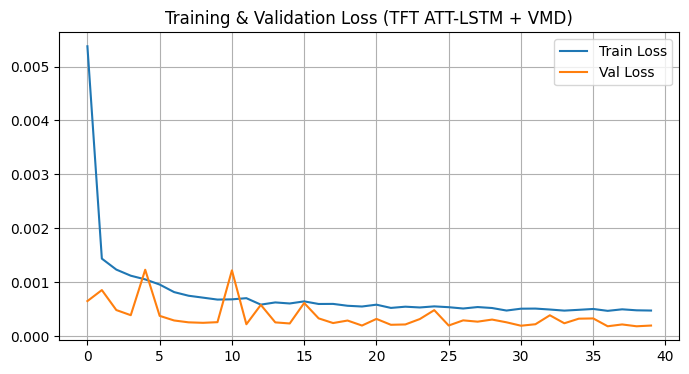

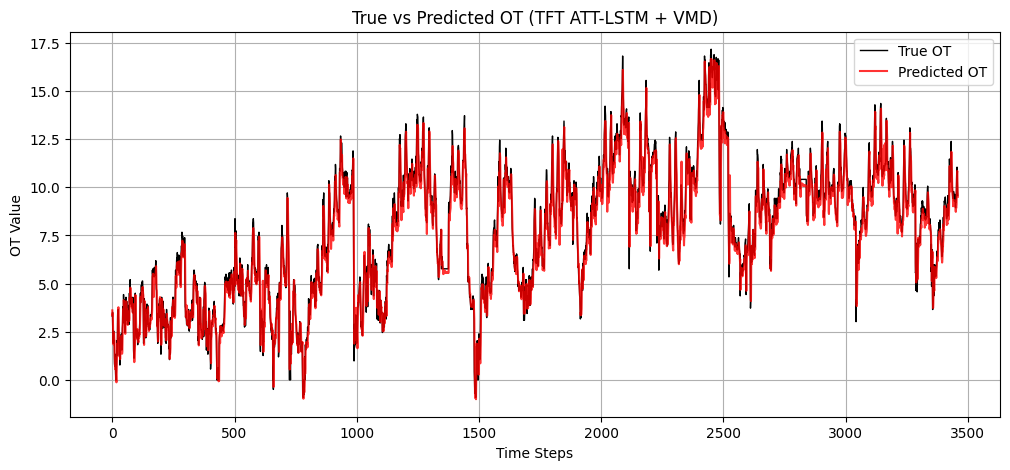

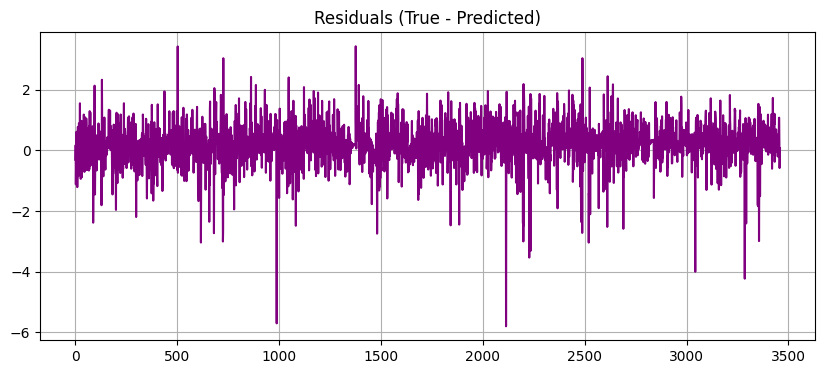

Total Area = 1795.0482549685994
Area + = 1289.4711621683105
Area - = -505.57709280028905


In [75]:
model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 24, 128)   │     72,192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 24, 128)   │     72,192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 128)   │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 128)   │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_3[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_4[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     29,056 │ lambda_1[0][0],   │
│ (TFTTemporalAttent… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32)        │     10,368 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 217,121 (848.13 KB)

 Trainable params: 217,121 (848.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0053 - mae: 0.0454 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0016 - mae: 0.0307 - val_loss: 6.2200e-04 - val_mae: 0.0186
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 5.0563e-04 - val_mae: 0.0167
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0011 - mae: 0.0256 - val_loss: 4.4947e-04 - val_mae: 0.0156
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 4.1915e-04 - val_mae: 0.0151
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0010 - mae: 0.0245 - val_loss: 5.9671e-04 - val_mae: 0.0190
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 9.5040e-04 - mae: 0.0232 - val_loss: 4.1186e-04 - val_mae: 0.0148
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 8.4672e-04 - mae: 0.0218 - val_loss: 3.0073e-04 - val_mae: 0.0123
Epoch 9/40
4

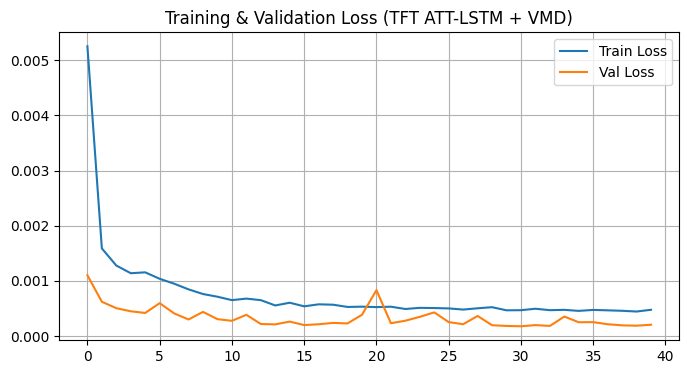

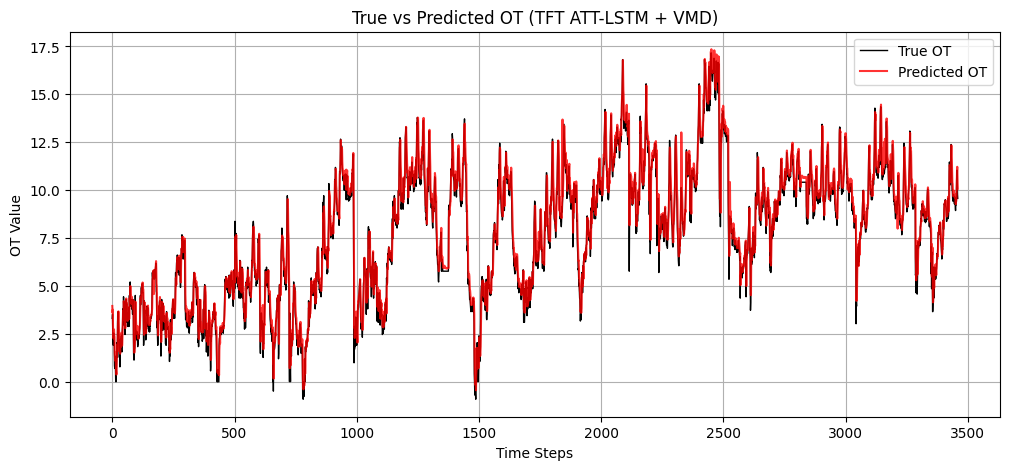

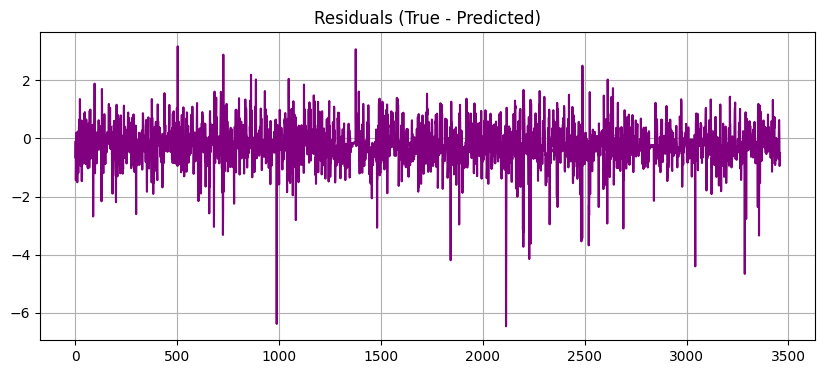

Total Area = 1771.4321410106488
Area + = 522.6581844910984
Area - = -1248.7739565195507


In [10]:
model_build_TFTattlstm_model = build_TFTattlstm_model2(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_100 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_101 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_78 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_100[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_80 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_101[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 24, 64)    │          0 │ lstm_78[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 24, 64)    │          0 │ lstm_80[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_82[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_83[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_102 (Lambda) │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_103 (Lambda) │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (None, 8)         │      2,208 │ lambda_102[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_25    │ (None, 8)         │      2,208 │ lambda_103[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │     73,216 │ bidirectional_24… │
│ (TFTTemporalAttent… │                   │            │ bidirectional_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_26    │ (None, 8)         │      8,352 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 1)         │          9 │ bidirectional_26… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130,793 (510.91 KB)

 Trainable params: 130,793 (510.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0065 - mae: 0.0453 - val_loss: 8.9983e-04 - val_mae: 0.0224
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0016 - mae: 0.0305 - val_loss: 8.4311e-04 - val_mae: 0.0232
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 4.8028e-04 - val_mae: 0.0160
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 6.2633e-04 - val_mae: 0.0188
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 4.5005e-04 - val_mae: 0.0153
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 0.0015 - val_mae: 0.0337
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0011 - mae: 0.0251 - val_loss: 4.9245e-04 - val_mae: 0.0170
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 4.5517e-04 - val_mae: 0.0159
Epoch 9/40
435/435 

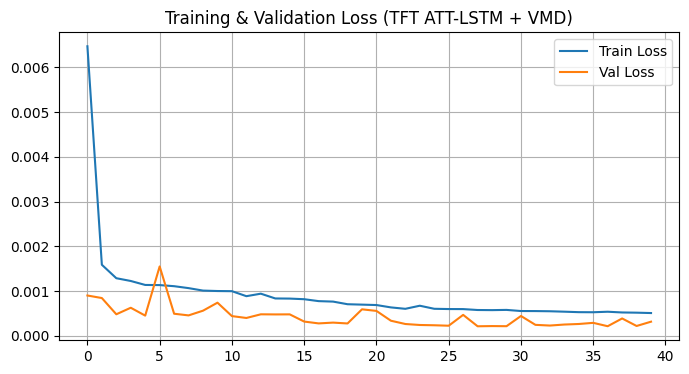

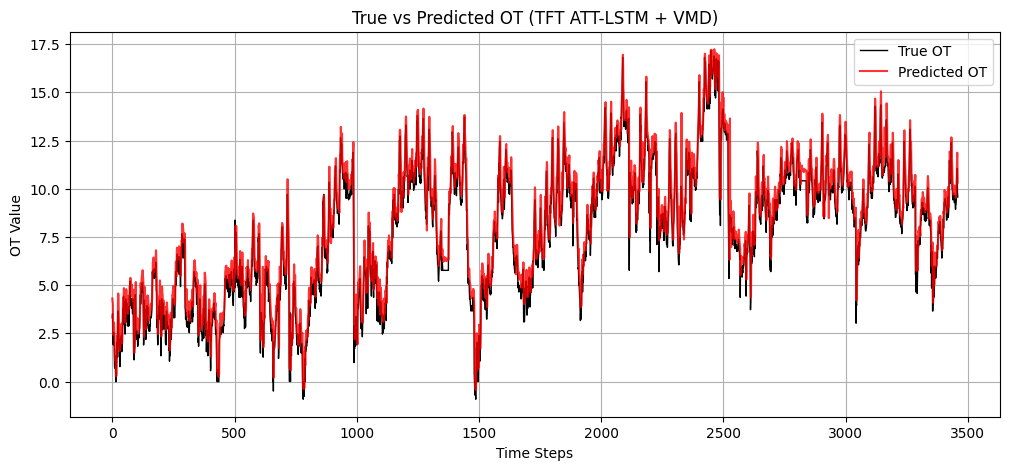

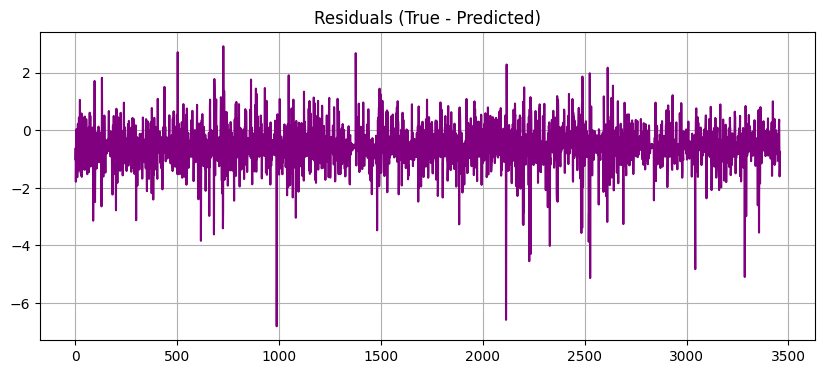

Total Area = 2370.494404671713
Area + = 257.41418507695226
Area - = -2113.080219594761


In [51]:
model_build_TFTattlstm_model = build_TFTattlstm_model3(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=64,
    dense_units=4,
    num_heads=64,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_113 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_112 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_89 (LSTM)      │ (None, 24, 32)    │      4,992 │ lambda_113[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_88 (LSTM)      │ (None, 24, 32)    │      4,992 │ lambda_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 24, 32)    │          0 │ lstm_89[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_94          │ (None, 24, 32)    │          0 │ lstm_88[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_95[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_94[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_115 (Lambda) │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_114 (Lambda) │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention_7   │ (None, 1, 32)     │     67,104 │ lambda_115[0][0], │
│ (CrossAttention)    │                   │            │ lambda_114[0][0], │
│                     │                   │            │ lambda_114[0][0], │
│                     │                   │            │ lambda_115[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 2, 32)     │          0 │ cross_attention_… │
│ (Concatenate)       │                   │            │ cross_attention_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 32)     │     67,104 │ concatenate_15[0… │
│ (MultiHeadAttentio… │                   │            │ concatenate_15[0… │
│                     │                   │            │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 2, 32)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 32)     │         64 │ dropout_98[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_28    │ (None, 8)         │      1,184 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 1)         │          9 │ bidirectional_28

 Total params: 147,625 (576.66 KB)

 Trainable params: 147,625 (576.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0083 - mae: 0.0585 - val_loss: 6.8210e-04 - val_mae: 0.0190
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0019 - mae: 0.0336 - val_loss: 7.2015e-04 - val_mae: 0.0202
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 4.8905e-04 - val_mae: 0.0161
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 6.0203e-04 - val_mae: 0.0183
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0013 - mae: 0.0274 - val_loss: 0.0012 - val_mae: 0.0293
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0013 - mae: 0.0270 - val_loss: 5.0501e-04 - val_mae: 0.0171
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 4.8854e-04 - val_mae: 0.0170
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 3.7926e-04 - val_mae: 0.0143
Epoch 9/40
435/435 

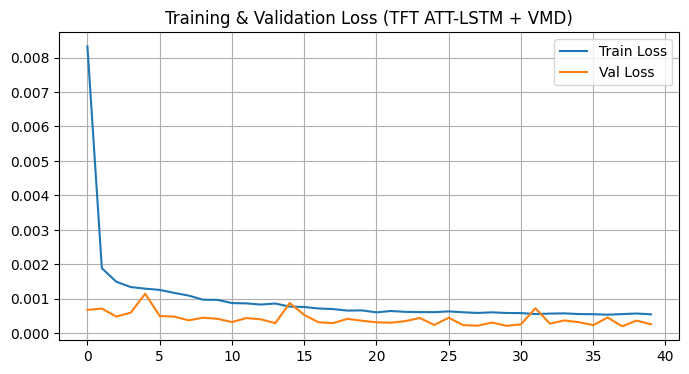

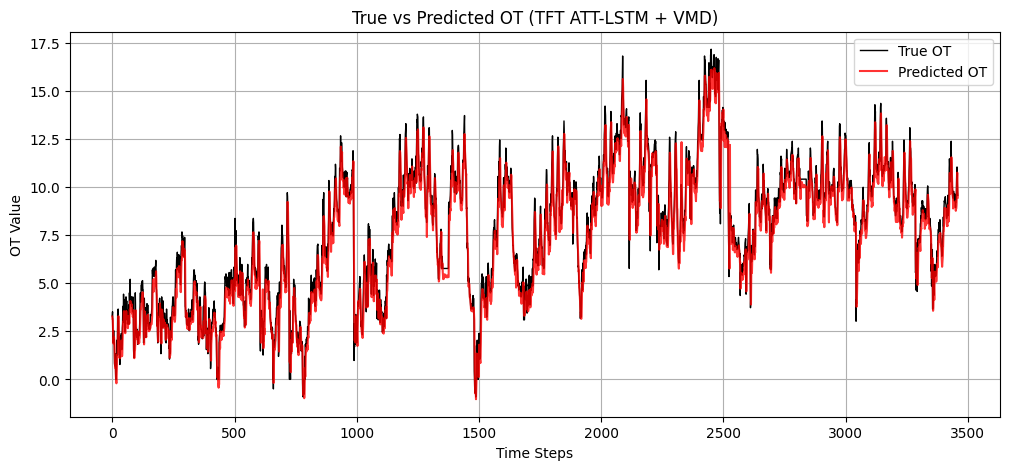

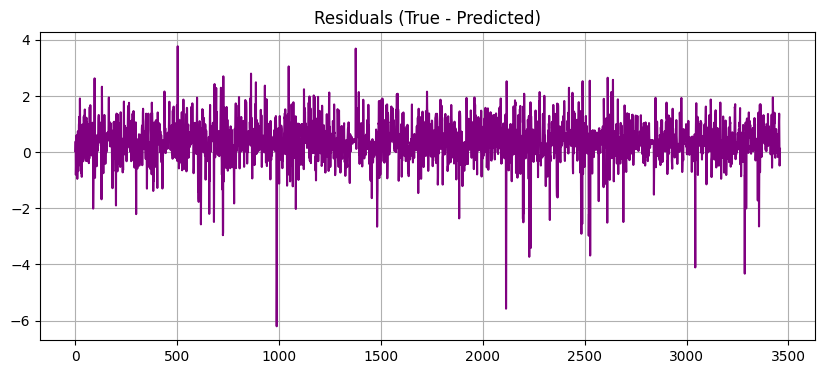

Total Area = 2146.068624179811
Area + = 1763.3979604244246
Area - = -382.6706637553868


In [56]:
model_build_TFTattlstm_model = build_TFTattlstm_model4(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=32,
    dense_units=4,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_130 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_131 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_104 (LSTM)     │ (None, 24, 64)    │     18,176 │ lambda_130[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_105 (LSTM)     │ (None, 24, 64)    │     18,176 │ lambda_131[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_122         │ (None, 24, 64)    │          0 │ lstm_104[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_123         │ (None, 24, 64)    │          0 │ lstm_105[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_122[0][0] │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_123[0][0] │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_132 (Lambda) │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_133 (Lambda) │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 2, 64)     │          0 │ lambda_132[0][0], │
│ (Concatenate)       │                   │            │ lambda_133[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 128)       │          0 │ concatenate_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_208 (Dense)   │ (None, 16)        │      2,064 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_209 (Dense)   │ (None, 16)        │      2,064 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_divergence_laye… │ [(None, 16),      │          0 │ dense_208[0][0],  │
│ (KLDivergenceLayer) │ (None, 16)]       │            │ dense_209[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_6          │ (None, 16)        │          0 │ kl_divergence_la… │
│ (Sampling)          │                   │            │ kl_divergence_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_210 (Dense)   │ (None, 64)        │      1,088 │ sampling_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_211 (Dense)   │ (None, 128)       │      8,320 │ dense_210[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 2, 64)     │          0 │ dense_211[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │    116,224 │ reshape_5[0][0],

 Total params: 191,537 (748.19 KB)

 Trainable params: 191,537 (748.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0344 - mae: 0.1443 - val_loss: 0.0228 - val_mae: 0.1353
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0316 - mae: 0.1410 - val_loss: 0.0238 - val_mae: 0.1388
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0316 - mae: 0.1408 - val_loss: 0.0230 - val_mae: 0.1359
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0315 - mae: 0.1408 - val_loss: 0.0237 - val_mae: 0.1386
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0316 - mae: 0.1410 - val_loss: 0.0244 - val_mae: 0.1411
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0316 - mae: 0.1408 - val_loss: 0.0274 - val_mae: 0.1512
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0263 - val_mae: 0.1474
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0315 - mae: 0.1409 - val_loss: 0.0218 - val_mae: 0.1318
Epoch 9/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms

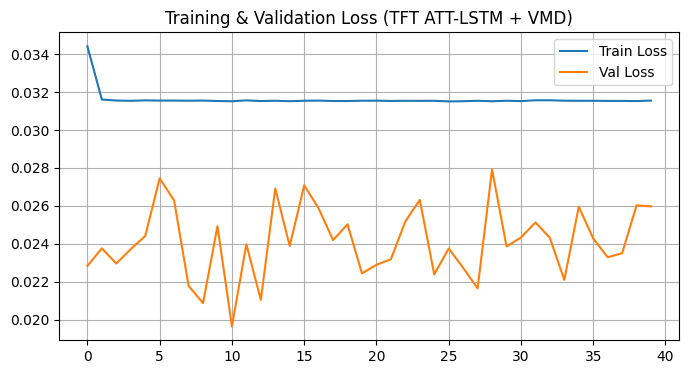

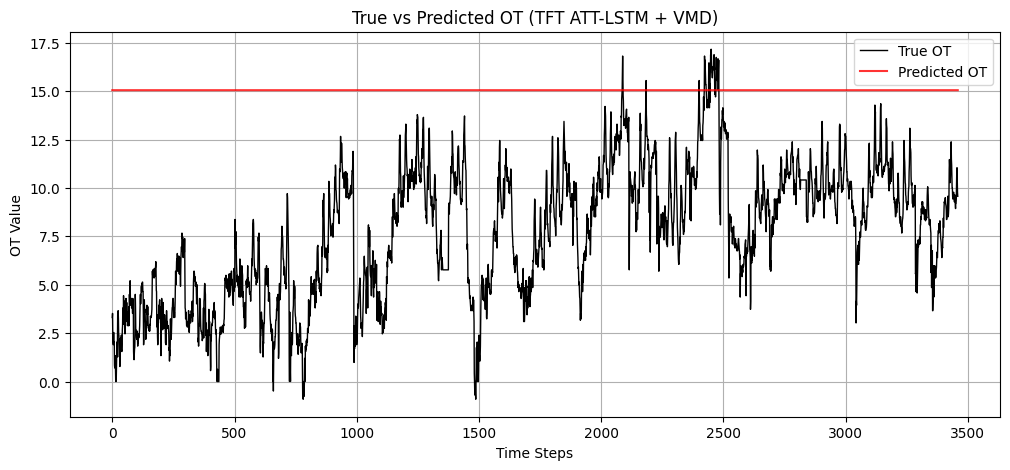

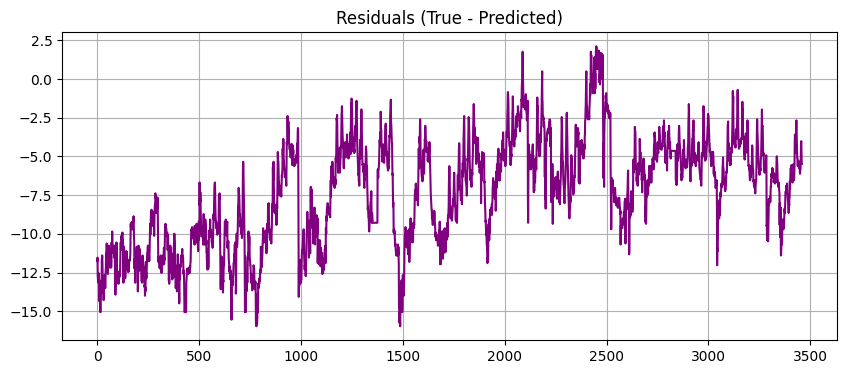

Total Area = 25353.316216796637
Area + = 50.71634769439697
Area - = -25302.59986910224


In [74]:
model_build_TFTattlstm_model = build_TFTattlstm_model5(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=8,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_128 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_129 (Lambda) │ (None, 24, 6)     │          0 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_102 (LSTM)     │ (None, 24, 64)    │     18,176 │ lambda_128[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_103 (LSTM)     │ (None, 24, 64)    │     18,176 │ lambda_129[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_118         │ (None, 24, 64)    │          0 │ lstm_102[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_119         │ (None, 24, 64)    │          0 │ lstm_103[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 256)   │    115,776 │ dropout_118[0][0… │
│ (PerformerAttentio… │                   │            │ dropout_118[0][0… │
│                     │                   │            │ dropout_118[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 256)   │    115,776 │ dropout_119[0][0… │
│ (PerformerAttentio… │                   │            │ dropout_119[0][0… │
│                     │                   │            │ dropout_119[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 256)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 256)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 512)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_206 (Dense)   │ (None, 8)         │      4,104 │ concatenate_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_207 (Dense)   │ (None, 1)         │          9 │ dense_206[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,017 (1.04 MB)

 Trainable params: 271,889 (1.04 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0039 - mae: 0.0393 - val_loss: 0.0017 - val_mae: 0.0364
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 4.6051e-04 - val_mae: 0.0161
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 9.3032e-04 - mae: 0.0229 - val_loss: 3.4431e-04 - val_mae: 0.0132
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 7.8471e-04 - mae: 0.0208 - val_loss: 6.5756e-04 - val_mae: 0.0221
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 7.1914e-04 - mae: 0.0199 - val_loss: 2.5771e-04 - val_mae: 0.0111
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.6365e-04 - mae: 0.0190 - val_loss: 2.4878e-04 - val_mae: 0.0110
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.4001e-04 - mae: 0.0186 - val_loss: 2.4249e-04 - val_mae: 0.0108
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 6.3730e-04 - mae: 0.0186 - val_loss: 2.3143e-04 - val_mae: 0.0

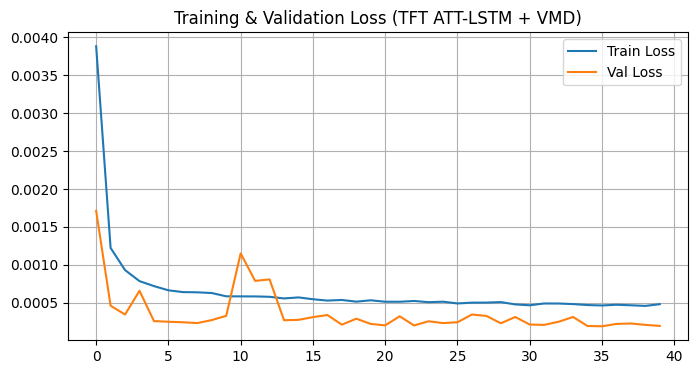

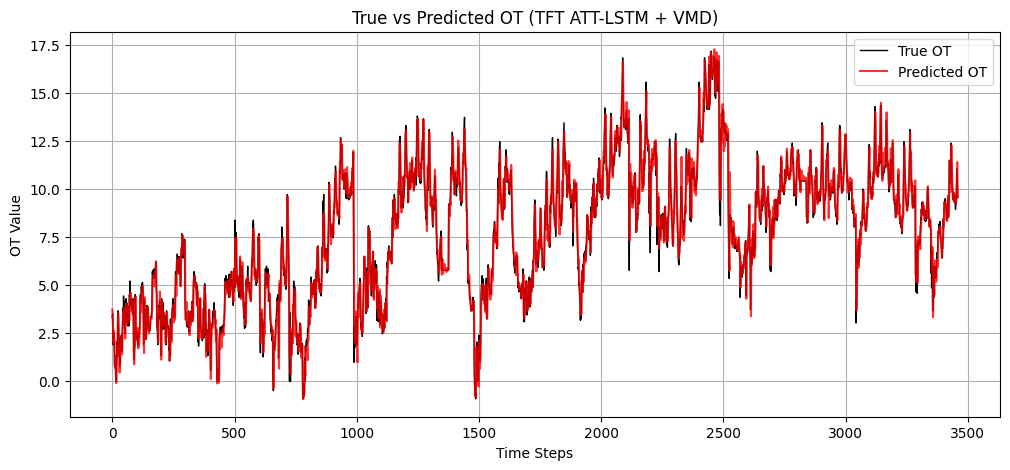

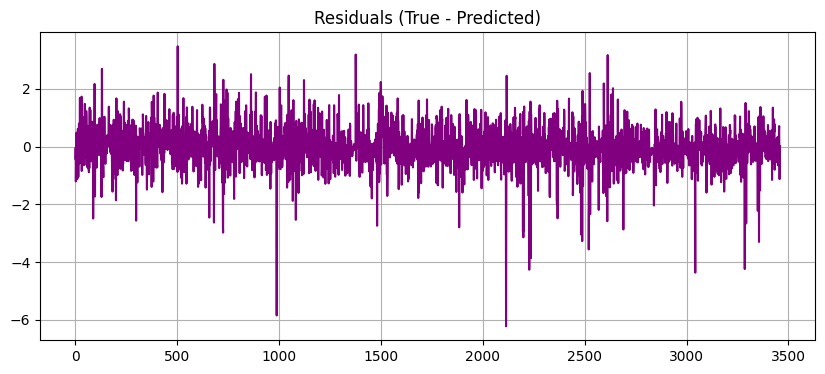

Total Area = 1684.5162377217785
Area + = 841.8495533028624
Area - = -842.6666844189159


In [73]:
model_build_TFTattlstm_model = build_TFTattlstm_model6(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=32,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_114 (LSTM)     │ (None, 24, 84)    │     32,592 │ input_layer_43[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_134         │ (None, 24, 84)    │          0 │ lstm_114[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_115 (LSTM)     │ (None, 24, 84)    │     32,592 │ input_layer_43[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 84)        │      7,224 │ dropout_134[0][0] │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_135         │ (None, 24, 84)    │          0 │ lstm_115[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_bahdanau_ex… │ (None, 1, 84)     │          0 │ attention_layer_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 256)   │    131,136 │ dropout_135[0][0… │
│ (PerformerAttentio… │                   │            │ dropout_135[0][0… │
│                     │                   │            │ dropout_135[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 84)        │          0 │ group1_bahdanau_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 256)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 340)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_240 (Dense)   │ (None, 8)         │      2,728 │ concatenate_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_241 (Dense)   │ (None, 1)         │          9 │ dense_240[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 206,281 (805.79 KB)

 Trainable params: 206,217 (805.54 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0386 - mse: 0.0033 - val_loss: 0.0192 - val_mse: 6.4103e-04
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0309 - mse: 0.0016 - val_loss: 0.0174 - val_mse: 5.5813e-04
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0265 - mse: 0.0012 - val_loss: 0.0207 - val_mse: 6.7670e-04
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0239 - mse: 0.0010 - val_loss: 0.0147 - val_mse: 3.9753e-04
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0224 - mse: 8.8216e-04 - val_loss: 0.0139 - val_mse: 3.6468e-04
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0204 - mse: 7.5761e-04 - val_loss: 0.0134 - val_mse: 3.2969e-04
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0195 - mse: 6.9807e-04 - val_loss: 0.0118 - val_mse: 2.6619e-04
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0173 - mse: 5.6530e-04 - val_loss: 0.0123 - val_mse: 2.6592e-04


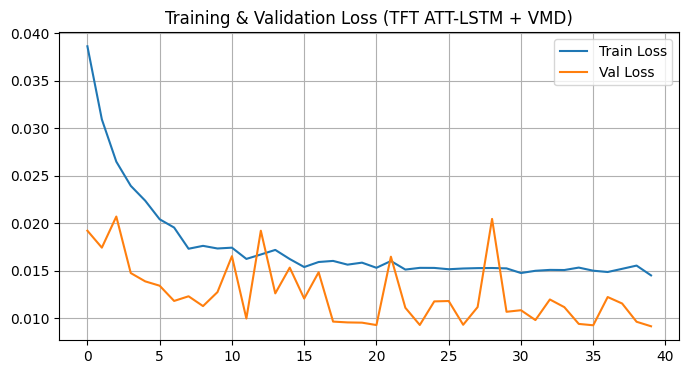

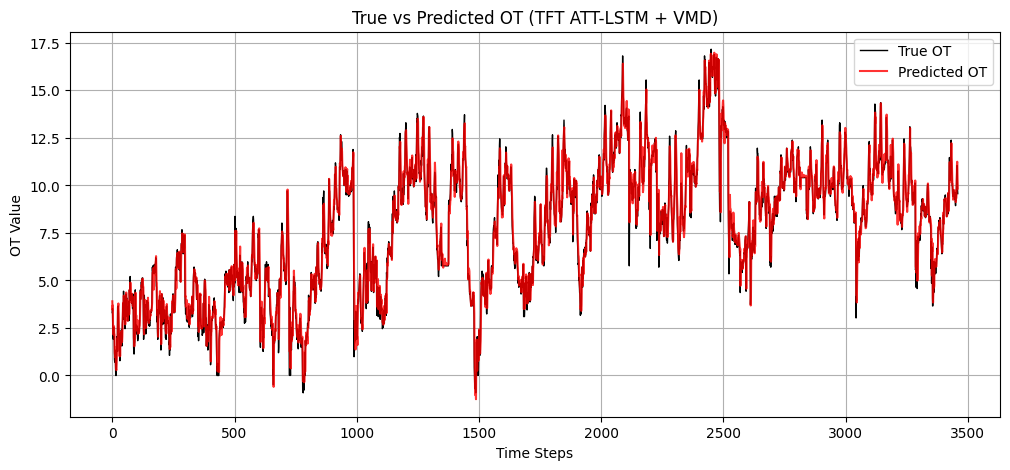

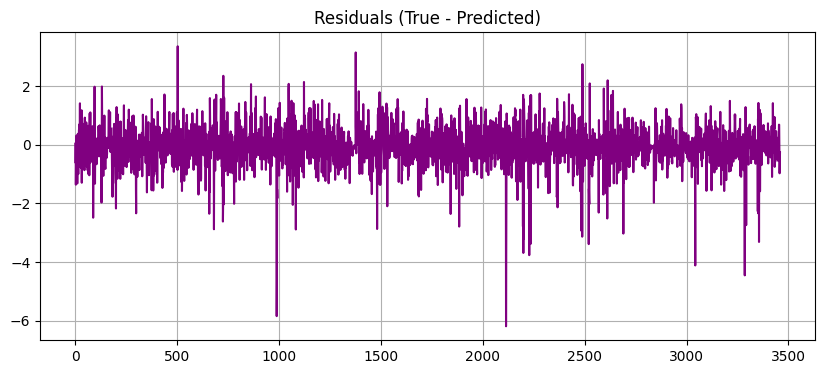

Total Area = 1581.6603190377355
Area + = 700.6741566509015
Area - = -880.9861623868338


In [80]:
model_build_TFTattlstm_model = build_TFTattlstm_model7(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=84,
    dense_units=8,
    num_heads=32,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

# AttnLSTM+SIMPLE

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 24, 122)        │        60,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 122)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_9     │ (None, 122)            │        15,128 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0065 - mae: 0.0510 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0025 - mae: 0.0384 - val_loss: 9.7401e-04 - val_mae: 0.0231
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0017 - mae: 0.0316 - val_loss: 9.4897e-04 - val_mae: 0.0248
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 4.8883e-04 - val_mae: 0.0180
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.5724e-04 - mae: 0.0217 - val_loss: 2.8119e-04 - val_mae: 0.0123
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7.2532e-04 - mae: 0.0197 - val_loss: 3.4734e-04 - val_mae: 0.0144
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.7161e-04 - mae: 0.0190 - val_loss: 1.9752e-04 - val_mae: 0.0097
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.2450e-04 - mae: 0.0183 - val_loss: 2.3854e-04 - val_mae: 0.0112
Epoc

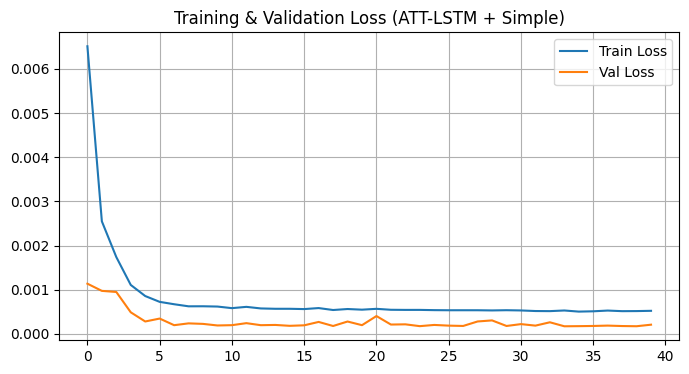

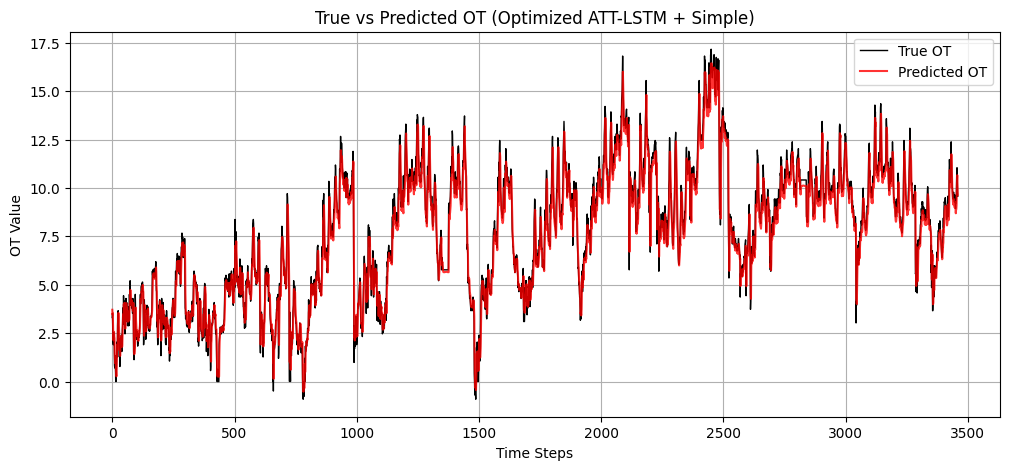

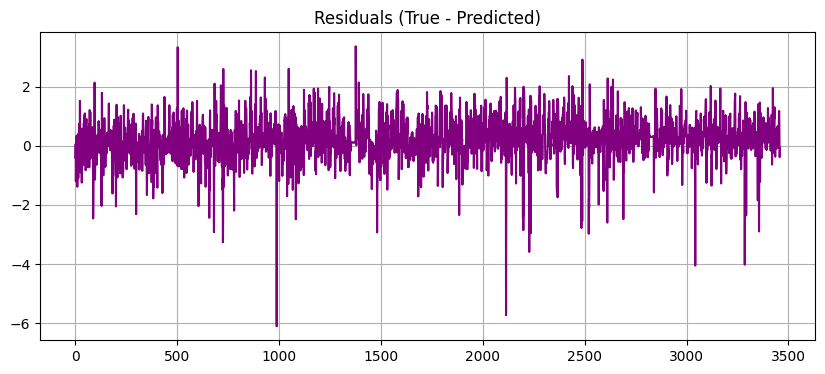

Total Area = 1809.2816908399118
Area + = 1268.6727049353078
Area - = -540.6089859046039


In [21]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple_scaled.shape[-1]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)

model_build_attlstm_model.summary()

history_attlstm_simple = model_build_attlstm_model.fit(
    X_train_simple_scaled, y_train_simple_scaled,
    validation_data=(X_test_simple_scaled, y_test_simple_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model_build_attlstm_model.predict(X_test_simple_scaled)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_attlstm_simple_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
area_total_attlstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_simple)
area_positive_attlstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_simple)
print("Area - =", area_negative_attlstm_simple)

# BidirectionalLSTM_SIMPLE

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 24, 200)        │        87,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,701 (811.33 KB)

 Trainable params: 207,701 (811.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0032 - mae: 0.0376 - val_loss: 4.3515e-04 - val_mae: 0.0160
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 2.6971e-04 - val_mae: 0.0117
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 2.4936e-04 - val_mae: 0.0114
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9.8492e-04 - mae: 0.0233 - val_loss: 2.1845e-04 - val_mae: 0.0104
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.5313e-04 - mae: 0.0216 - val_loss: 2.0073e-04 - val_mae: 0.0099
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7.8888e-04 - mae: 0.0206 - val_loss: 2.2467e-04 - val_mae: 0.0107
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 7.4166e-04 - mae: 0.0198 - val_loss: 2.2450e-04 - val_mae: 0.0110
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7.1122e-04 - mae: 0.0194 - val_loss: 1.9713e-04 - val_mae: 0.0

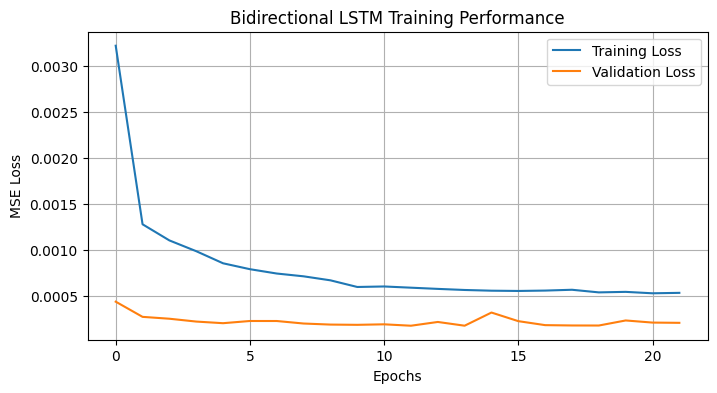

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


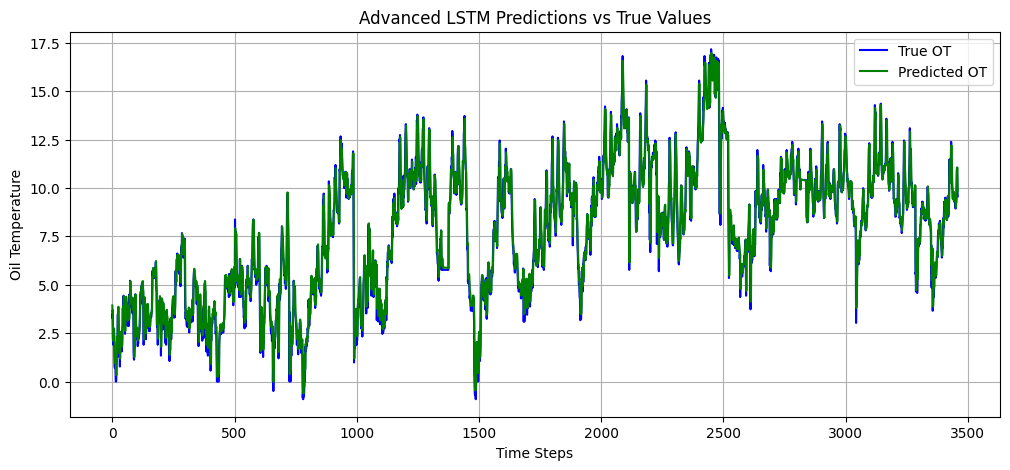

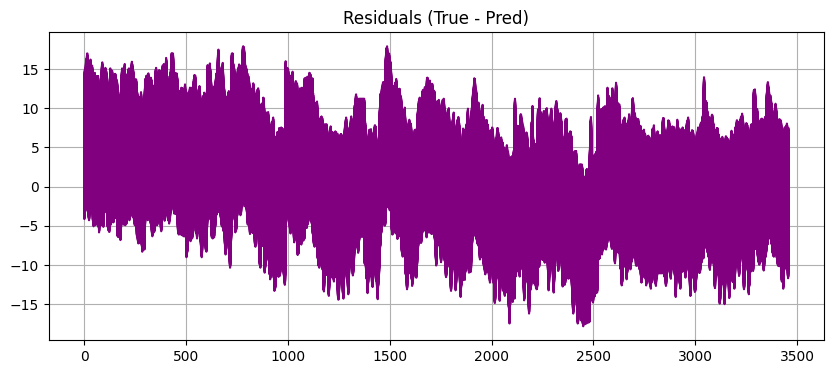

Total Area = 1575.757561193779
Area + = 699.7469725813723
Area - = -876.0105886124068


In [22]:
# ---------------------------
# 5. Build Bidirectional_LSTM model
# ---------------------------
def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, K_hat),100)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple_scaled, y_train_simple_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple_scaled, y_test_simple_scaled),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_Bidirectional_lstm_simple.history['loss'], label='Training Loss')
plt.plot(history_Bidirectional_lstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Bidirectional LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple_scaled)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_pred_Bidirectional_lstm_simple_true - y_test_simple_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_simple_true.squeeze() - y_pred_Bidirectional_lstm_simple_true
area_total_Bidirectional_lstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Bidirectional_lstm_simple)
area_positive_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Bidirectional_lstm_simple)
print("Area - =", area_negative_Bidirectional_lstm_simple)

# LSTM_VMD

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,857 (788.50 KB)

 Trainable params: 201,857 (788.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0040 - mae: 0.0409 - val_loss: 3.7557e-04 - val_mae: 0.0141
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 5.7554e-04 - val_mae: 0.0188
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0012 - val_mae: 0.0303
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 4.0589e-04 - val_mae: 0.0162
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.5367e-04 - mae: 0.0231 - val_loss: 2.1574e-04 - val_mae: 0.0102
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.8215e-04 - mae: 0.0220 - val_loss: 2.0814e-04 - val_mae: 0.0101
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.0809e-04 - mae: 0.0210 - val_loss: 3.1854e-04 - val_mae: 0.0137
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7.6255e-04 - mae: 0.0204 - val_loss: 6.7670e-04 - val_mae: 0.0226
Epoch 

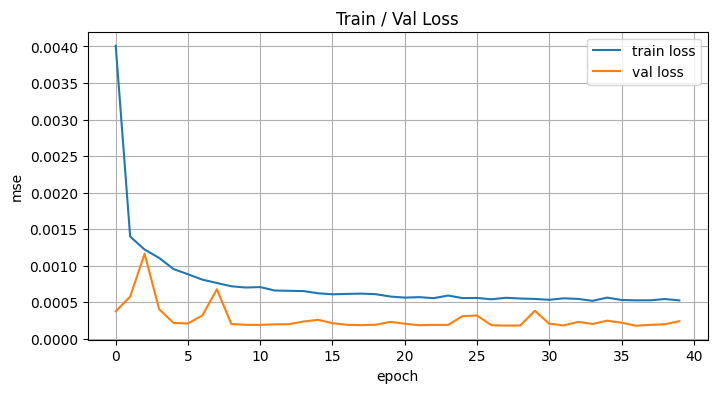

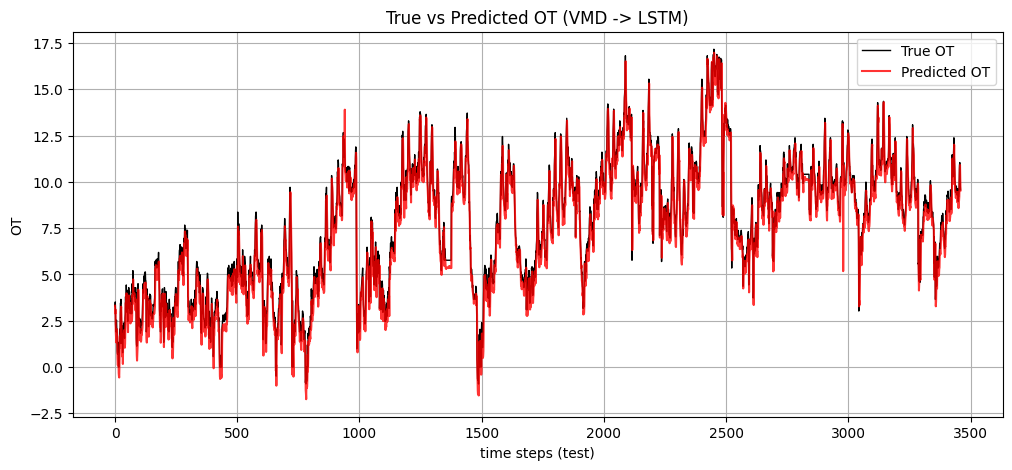

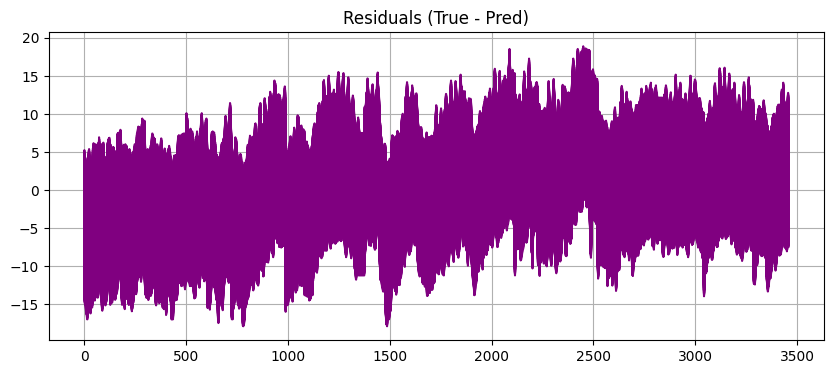

Total Area = 2016.9030818054462
Area + = 1662.7967645041656
Area - = -354.10631730128057


In [23]:
# ---------------------------
# 5. Build LSTM model
# ---------------------------
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model_lstm_model= build_lstm_model((SEQ_LEN, K_hat),128)
model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model_lstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model_lstm_model.predict(X_test_vmd_scaled)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (VMD -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_vmd_true - y_pred_lstm_vmd_true 
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_lstm_vmd_true
area_total_lstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm_vmd)
area_positive_lstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm_vmd)
print("Area - =", area_negative_lstm_vmd)

# Compare Models

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd = compute_metrics(y_pred_attlstm_vmd_true, y_test_vmd_true)
mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd = compute_metrics(y_pred_Tattlstm_vmd_true, y_test_vmd_true)
mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd = compute_metrics(y_pred_TFTattlstm_vmd_true, y_test_vmd_true)
mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple, mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple, r2_attlstm_simple = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(y_pred_lstm_vmd_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD: MSE={mse_Attlstm_vmd:.4f}, RMSE={rmse_Attlstm_vmd:.4f}, MAE={mae_Attlstm_vmd:.4f}, R²={r2_attlstm_vmd:.4f}, total_area={area_total_attlstm_vmd:.4f}")
print(f"TATT-LSTM-VMD: MSE={mse_TAttlstm_vmd:.4f}, RMSE={rmse_TAttlstm_vmd:.4f}, MAE={mae_TAttlstm_vmd:.4f}, R²={r2_Tattlstm_vmd:.4f}, total_area={area_total_Tattlstm_vmd:.4f}")
print(f"TFTATT-LSTM-VMD: MSE={mse_TFTAttlstm_vmd:.4f}, RMSE={rmse_TFTAttlstm_vmd:.4f}, MAE={mae_TFTAttlstm_vmd:.4f}, R²={r2_TFTattlstm_vmd:.4f}, total_area={area_total_TFTattlstm_vmd:.4f}")
print(f"Bidirectional_Lstm_Simple: MSE={mse_Lstm_Bidirectional_simple:.4f}, RMSE={rmse_Lstm_Bidirectional_simple:.4f}, MAE={mae_Lstm_Bidirectional_simple:.4f}, R²={r2_Lstm_Bidirectional_simple:.4f}, total_area={area_total_Bidirectional_lstm_simple:.4f}")
print(f"Attlstm_Simple: MSE={mse_Attlstm_simple:.4f}, RMSE={rmse_Attlstm_simple:.4f}, MAE={mae_Attlstm_simple:.4f}, R²={r2_attlstm_simple:.4f}, total_area={area_total_attlstm_simple:.4f}")
print(f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}, total_area={area_total_lstm_vmd:.4f}")


📈 Model Performance Comparison
ATT-LSTM-VMD: MSE=0.6866, RMSE=0.8286, MAE=0.6434, R²=0.9357, total_area=2225.9058
TATT-LSTM-VMD: MSE=0.6281, RMSE=0.7925, MAE=0.5990, R²=0.9491, total_area=2072.4574
TFTATT-LSTM-VMD: MSE=0.9493, RMSE=0.9743, MAE=0.7686, R²=0.9007, total_area=2658.3283
Bidirectional_Lstm_Simple: MSE=0.4345, RMSE=0.6592, MAE=0.4556, R²=0.9611, total_area=1575.7576
Attlstm_Simple: MSE=0.5235, RMSE=0.7236, MAE=0.5230, R²=0.9506, total_area=1809.2817
Lstm_vmd: MSE=0.6006, RMSE=0.7750, MAE=0.5829, R²=0.9513, total_area=2016.9031


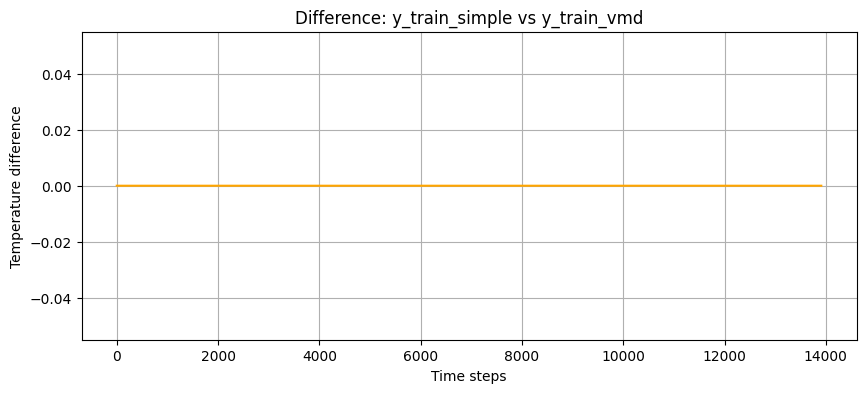

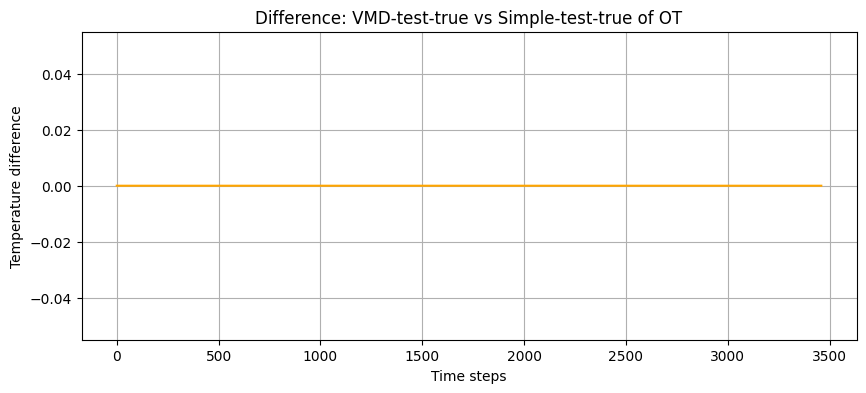

In [25]:
diff = y_train_simple_scaled - y_train_vmd_scaled
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: y_train_simple vs y_train_vmd')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd_scaled)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple_scaled)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-test-true vs Simple-test-true of OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()